# How do meteorological conditions, such as temperature and wind, impact ozone levels, and how does this relationship differ across geographic locations within the Northeast corridor of the United States over the years 2016 to 2023?

## Data Pre-Processing

In [1]:
# imports
import pandas as pd
import zipfile
import os
import numpy as np
from scipy.stats import chi2_contingency
from statsmodels.formula.api import ols
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pingouin as pg

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/krithikanatarajan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
folders = ['ozone', 'wind', 'Barometric Pressure', 'RH and Dewpoint', 'temperature']
dataframes = {}  # Dictionary to store dataframes 

In [3]:
for folder in folders:
    print(folder)
    data = pd.DataFrame()
    for zip_file in os.listdir(folder):
        data_folder = folder
        # Construct the full path to the ZIP file
        zip_file_path = os.path.join(data_folder, zip_file)
        
        # Make sure to only process ZIP files
        if zipfile.is_zipfile(zip_file_path):
            with zipfile.ZipFile(zip_file_path, 'r') as z:
                # Assuming there's only one CSV file per ZIP, get its name
                csv_files = [f for f in z.namelist() if f.endswith('.csv')]
                for csv_file in csv_files:
                    # Open and read the CSV file
                    with z.open(csv_file) as f:
                        df = pd.read_csv(f, dtype={'Event Type': str})
                        data = pd.concat([data, df], ignore_index=True)
                        dataframes[data_folder] = data
                    

ozone
wind
Barometric Pressure
RH and Dewpoint
temperature


In [4]:
ozone = dataframes['ozone'][['Site Num', 'POC', 'Parameter Name', 'Date Local', 'Event Type', 'Method Code',
            'State Name', 'County Name', 'City Name', 'Arithmetic Mean', '1st Max Value', '1st Max Hour', 'AQI']].copy()

wind = dataframes['wind'][['Site Num', 'POC', 'Parameter Name', 'Date Local', 'Event Type', 'Method Code',
            'State Name', 'County Name', 'City Name', 'Arithmetic Mean', '1st Max Value', '1st Max Hour']].copy()

pressure = dataframes['Barometric Pressure'][['Site Num', 'POC', 'Parameter Name', 'Date Local', 'Event Type', 'Method Code',
            'State Name', 'County Name', 'City Name', 'Arithmetic Mean', '1st Max Value', '1st Max Hour']].copy()

rhd = dataframes['RH and Dewpoint'][['Site Num', 'POC', 'Parameter Name', 'Date Local', 'Event Type', 'Method Code',
            'State Name', 'County Name', 'City Name', 'Arithmetic Mean', '1st Max Value', '1st Max Hour']].copy()

temp = dataframes['temperature'][['Site Num', 'POC', 'Parameter Name', 'Date Local', 'Event Type', 'Method Code',
            'State Name', 'County Name', 'City Name', 'Arithmetic Mean', '1st Max Value', '1st Max Hour']].copy()

In [5]:
unique_columns = ['Date Local', 'State Name', 
                  'County Name', 'City Name']

columns_to_rename = ['Arithmetic Mean', '1st Max Value', '1st Max Hour']

In [6]:
dew_point_data = rhd[rhd['Parameter Name'] == 'Dew Point'].copy()

# Step 2: Rename columns in the dew point subset
rename_dict = {col: col + '_dewpoint' for col in columns_to_rename}
dew_point_data.rename(columns=rename_dict, inplace=True)

In [7]:
rhd = rhd[rhd['Parameter Name'] != 'Dew Point']

In [8]:
rename_dict = {col: col + '_ozone' for col in columns_to_rename}
ozone.rename(columns=rename_dict, inplace=True)
ozone.head()

rename_dict = {col: col + '_wind' for col in columns_to_rename}
wind.rename(columns=rename_dict, inplace=True)
wind.head()


rename_dict = {col: col + '_pressure' for col in columns_to_rename}
pressure.rename(columns=rename_dict, inplace=True)
pressure.head()

rename_dict = {col: col + '_rhd' for col in columns_to_rename}
rhd.rename(columns=rename_dict, inplace=True)
rhd.head()


rename_dict = {col: col + '_temp' for col in columns_to_rename}
temp.rename(columns=rename_dict, inplace=True)

In [9]:
merged = pd.merge(ozone, wind, how='inner', on=unique_columns)

In [10]:
merged.head()

,Site Num_x,POC_x,Parameter Name_x,Date Local,Event Type_x,Method Code_x,State Name,County Name,City Name,Arithmetic Mean_ozone,...,1st Max Hour_ozone,AQI,Site Num_y,POC_y,Parameter Name_y,Event Type_y,Method Code_y,Arithmetic Mean_wind,1st Max Value_wind,1st Max Hour_wind
0,23,1,Ozone,2016-01-01,NaN,87.0,Alabama,Jefferson,Birmingham,0.023882,...,13,25,23,1,Wind Speed - Resultant,NaN,61,1.679167,2.3,8
1,23,1,Ozone,2016-01-01,NaN,87.0,Alabama,Jefferson,Birmingham,0.023882,...,13,25,23,1,Wind Direction - Resultant,NaN,61,270.791667,359.0,4
2,23,1,Ozone,2016-01-01,NaN,87.0,Alabama,Jefferson,Birmingham,0.023882,...,13,25,2059,1,Wind Speed - Resultant,NaN,61,1.220833,1.6,1
3,23,1,Ozone,2016-01-01,NaN,87.0,Alabama,Jefferson,Birmingham,0.023882,...,13,25,2059,1,Wind Direction - Resultant,NaN,61,308.666667,335.0,8
4,23,1,Ozone,2016-01-02,NaN,87.0,Alabama,Jefferson,Birmingham,0.012471,...,9,28,23,1,Wind Speed - Resultant,NaN,61,0.887500,2.1,10


In [11]:
merged.drop(columns=['POC_x', 'Method Code_x', 'Site Num_x', 'Parameter Name_x', 'Event Type_x', 'Site Num_y', 'POC_y', 'Parameter Name_y', 'Event Type_y',
       'Method Code_y'], inplace=True)

In [12]:
merged.columns

Index(['Date Local', 'State Name', 'County Name', 'City Name',
       'Arithmetic Mean_ozone', '1st Max Value_ozone', '1st Max Hour_ozone',
       'AQI', 'Arithmetic Mean_wind', '1st Max Value_wind',
       '1st Max Hour_wind'],
      dtype='object')

In [13]:
merged = merged.merge(temp, on=unique_columns, how='inner')

In [14]:
merged.columns

Index(['Date Local', 'State Name', 'County Name', 'City Name',
       'Arithmetic Mean_ozone', '1st Max Value_ozone', '1st Max Hour_ozone',
       'AQI', 'Arithmetic Mean_wind', '1st Max Value_wind',
       '1st Max Hour_wind', 'Site Num', 'POC', 'Parameter Name', 'Event Type',
       'Method Code', 'Arithmetic Mean_temp', '1st Max Value_temp',
       '1st Max Hour_temp'],
      dtype='object')

In [15]:
merged.drop(columns=['Site Num', 'POC', 'Parameter Name', 'Event Type',
       'Method Code'], inplace=True)


In [16]:
merged.columns

Index(['Date Local', 'State Name', 'County Name', 'City Name',
       'Arithmetic Mean_ozone', '1st Max Value_ozone', '1st Max Hour_ozone',
       'AQI', 'Arithmetic Mean_wind', '1st Max Value_wind',
       '1st Max Hour_wind', 'Arithmetic Mean_temp', '1st Max Value_temp',
       '1st Max Hour_temp'],
      dtype='object')

In [17]:
merged = merged.merge(rhd, on=unique_columns, how='inner')

In [18]:
merged.columns

Index(['Date Local', 'State Name', 'County Name', 'City Name',
       'Arithmetic Mean_ozone', '1st Max Value_ozone', '1st Max Hour_ozone',
       'AQI', 'Arithmetic Mean_wind', '1st Max Value_wind',
       '1st Max Hour_wind', 'Arithmetic Mean_temp', '1st Max Value_temp',
       '1st Max Hour_temp', 'Site Num', 'POC', 'Parameter Name', 'Event Type',
       'Method Code', 'Arithmetic Mean_rhd', '1st Max Value_rhd',
       '1st Max Hour_rhd'],
      dtype='object')

In [19]:
merged.drop(columns=['Site Num', 'POC', 'Parameter Name', 'Event Type',
       'Method Code'], inplace=True)

In [20]:
merged = merged.merge(pressure, on=unique_columns, how='inner')

In [21]:
merged.columns

Index(['Date Local', 'State Name', 'County Name', 'City Name',
       'Arithmetic Mean_ozone', '1st Max Value_ozone', '1st Max Hour_ozone',
       'AQI', 'Arithmetic Mean_wind', '1st Max Value_wind',
       '1st Max Hour_wind', 'Arithmetic Mean_temp', '1st Max Value_temp',
       '1st Max Hour_temp', 'Arithmetic Mean_rhd', '1st Max Value_rhd',
       '1st Max Hour_rhd', 'Site Num', 'POC', 'Parameter Name', 'Event Type',
       'Method Code', 'Arithmetic Mean_pressure', '1st Max Value_pressure',
       '1st Max Hour_pressure'],
      dtype='object')

In [22]:
merged.drop(columns=['Site Num', 'POC', 'Parameter Name', 'Event Type',
       'Method Code'], inplace=True)

In [23]:
merged.columns

Index(['Date Local', 'State Name', 'County Name', 'City Name',
       'Arithmetic Mean_ozone', '1st Max Value_ozone', '1st Max Hour_ozone',
       'AQI', 'Arithmetic Mean_wind', '1st Max Value_wind',
       '1st Max Hour_wind', 'Arithmetic Mean_temp', '1st Max Value_temp',
       '1st Max Hour_temp', 'Arithmetic Mean_rhd', '1st Max Value_rhd',
       '1st Max Hour_rhd', 'Arithmetic Mean_pressure',
       '1st Max Value_pressure', '1st Max Hour_pressure'],
      dtype='object')

In [24]:
states = ['Massachusetts', 'Connecticut', 'New York', 'New Jersey', 
          'Pennsylvania', 'Maryland', 'Delaware', 'Virginia', 'District of Columbia']

# Filter the DataFrame to include only rows where the 'State Name' column matches one of the states in the list
northeast = merged[merged['State Name'].isin(states)]

In [25]:
northeast.columns = northeast.columns.str.replace(' ', '_').str.replace('-', '_').str.lower()

In [26]:
northeast['state_name'].unique()

array(['Connecticut', 'Maryland', 'Massachusetts', 'New Jersey',
       'New York', 'Pennsylvania', 'Virginia'], dtype=object)

## ANOVA

- Compare the mean ozone levels and AQI across different seasons within each state in the Northeast corridor.
- Compare the mean temperature and wind speeds across different states to see if there are significant regional differences in these meteorological conditions.

In [27]:
# check 3 assumtions: Normality, Homogeneity of variance, Independence:


In [28]:
# Convert the 'Date Local' column to datetime:
northeast['date_local'] = pd.to_datetime(northeast['date_local'])

/var/folders/35/xbdmm2wd3k72qkcpkmtts3n40000gn/T/ipykernel_43533/1298101186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  northeast['date_local'] = pd.to_datetime(northeast['date_local'])


In [29]:
# Extract the season from the month:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

In [30]:
northeast.loc[:, 'Season'] = northeast['date_local'].dt.month.apply(get_season)

/var/folders/35/xbdmm2wd3k72qkcpkmtts3n40000gn/T/ipykernel_43533/808943961.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  northeast.loc[:, 'Season'] = northeast['date_local'].dt.month.apply(get_season)


In [31]:
grouped_data = northeast.groupby(['state_name', 'Season'])

In [32]:
for state in northeast['state_name'].unique():
    # Filter the dataframe for the current state
    df_state = northeast[northeast['state_name'] == state]
    
    # Welch's ANOVA for arithmetic_mean_ozone
    welch_ozone = pg.welch_anova(data=df_state, dv='arithmetic_mean_ozone', between='Season')
    print(f"Welch's ANOVA for {state} (Ozone):")
    print(welch_ozone)
    
    # Welch's ANOVA for AQI
    welch_aqi = pg.welch_anova(data=df_state, dv='aqi', between='Season')
    print(f"Welch's ANOVA for {state} (AQI):")
    print(welch_aqi)

Welch's ANOVA for Connecticut (Ozone):
   Source  ddof1        ddof2            F  p-unc       np2
0  Season      3  6446.192612  1459.544691    0.0  0.263396
Welch's ANOVA for Connecticut (AQI):
   Source  ddof1        ddof2            F  p-unc       np2
0  Season      3  6454.032894  1193.661175    0.0  0.203117
Welch's ANOVA for Maryland (Ozone):
   Source  ddof1         ddof2            F  p-unc       np2
0  Season      3  21551.633399  6297.106394    0.0  0.245985
Welch's ANOVA for Maryland (AQI):
   Source  ddof1        ddof2            F  p-unc       np2
0  Season      3  26343.69386  6317.229555    0.0  0.177053
Welch's ANOVA for Massachusetts (Ozone):
   Source  ddof1         ddof2            F  p-unc       np2
0  Season      3  20055.482886  5295.218701    0.0  0.283318
Welch's ANOVA for Massachusetts (AQI):
   Source  ddof1       ddof2            F  p-unc       np2
0  Season      3  19654.6724  4281.181825    0.0  0.236936
Welch's ANOVA for New Jersey (Ozone):
   Source  ddo

In [33]:
for state in northeast['state_name'].unique():
    levene_test = stats.levene(
    northeast[northeast['state_name'] == state]['arithmetic_mean_ozone'][northeast['Season'] == 'Spring'],
    northeast[northeast['state_name'] == state]['arithmetic_mean_ozone'][northeast['Season'] == 'Summer'],
    northeast[northeast['state_name'] == state]['arithmetic_mean_ozone'][northeast['Season'] == 'Fall'],
    northeast[northeast['state_name'] == state]['arithmetic_mean_ozone'][northeast['Season'] == 'Winter']
)
    print(f"Levene's test for {state}: Statistic={levene_test.statistic}, p-value={levene_test.pvalue}")

Levene's test for Connecticut: Statistic=50.0502631979926, p-value=3.894067678617505e-32
Levene's test for Maryland: Statistic=65.37778794833767, p-value=3.4244468492004284e-42
Levene's test for Massachusetts: Statistic=450.44463863421714, p-value=2.200090996257399e-287
Levene's test for New Jersey: Statistic=6.74377263569076, p-value=0.00016030437114909882
Levene's test for New York: Statistic=77.98397056346785, p-value=7.921819541359334e-50
Levene's test for Pennsylvania: Statistic=5.245056128417341, p-value=0.0013003149226785012
Levene's test for Virginia: Statistic=4.97364128456128, p-value=0.0018981057701238707


# Chi squared

In [34]:
nec = northeast.copy()

In [35]:
nec.columns

Index(['date_local', 'state_name', 'county_name', 'city_name',
       'arithmetic_mean_ozone', '1st_max_value_ozone', '1st_max_hour_ozone',
       'aqi', 'arithmetic_mean_wind', '1st_max_value_wind',
       '1st_max_hour_wind', 'arithmetic_mean_temp', '1st_max_value_temp',
       '1st_max_hour_temp', 'arithmetic_mean_rhd', '1st_max_value_rhd',
       '1st_max_hour_rhd', 'arithmetic_mean_pressure',
       '1st_max_value_pressure', '1st_max_hour_pressure', 'Season'],
      dtype='object')

In [36]:
# categorize temperature
nec['temp_category'] = pd.qcut(nec['arithmetic_mean_temp'], 3, labels=["low", "medium", "high"])

# Categorize wind speed
nec['wind_category'] = pd.qcut(nec['arithmetic_mean_wind'], 3, labels=["low", "medium", "high"])

In [37]:
nec['pressure_category'] = pd.qcut(nec['arithmetic_mean_pressure'], 3, labels=["low", "medium", "high"])


nec['rhd_category'] = pd.qcut(nec['arithmetic_mean_rhd'], 3, labels=["low", "medium", "high"])

In [38]:
bins = [0, 50, 100, 150, 200, 300, 500]
labels = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
nec['aqi_category'] = pd.cut(nec['aqi'], bins=bins, labels=labels, right=False)

In [39]:
meteo_categories = ['temp_category', 'wind_category', 'pressure_category', 'rhd_category']

# Loop through each meteorological variable
for category in meteo_categories:
    # Create a contingency table for the current category vs. AQI category
    contingency_table = pd.crosstab(nec[category], nec['aqi_category'])
    
    # Perform the Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Print results
    print(f"Chi-squared Test for {category} vs. AQI Category")
    print(f"Chi-squared Statistic: {chi2}, p-value: {p}\n")
    print(f"Contingency Table for {category}:\n{contingency_table}\n")

Chi-squared Test for temp_category vs. AQI Category
Chi-squared Statistic: 13490.78365152424, p-value: 0.0

Contingency Table for temp_category:
aqi_category    Good  Moderate  Unhealthy for Sensitive Groups  Unhealthy  \
temp_category                                                               
low            42070       310                               0          0   
medium         38920      3432                              60          0   
high           31646      9456                            1104         68   

aqi_category   Very Unhealthy  
temp_category                  
low                         0  
medium                      0  
high                        4  

Chi-squared Test for wind_category vs. AQI Category
Chi-squared Statistic: 455.4367424662617, p-value: 2.5289766632717047e-93

Contingency Table for wind_category:
aqi_category    Good  Moderate  Unhealthy for Sensitive Groups  Unhealthy  \
wind_category                                                      

# Multiple Linear Regression Analysis

In [40]:
northeastern = northeast.copy()

In [41]:
northeastern = pd.get_dummies(northeastern, columns=['Season'])

In [42]:
northeastern.head()

,date_local,state_name,county_name,city_name,arithmetic_mean_ozone,1st_max_value_ozone,1st_max_hour_ozone,aqi,arithmetic_mean_wind,1st_max_value_wind,...,arithmetic_mean_rhd,1st_max_value_rhd,1st_max_hour_rhd,arithmetic_mean_pressure,1st_max_value_pressure,1st_max_hour_pressure,Season_Fall,Season_Spring,Season_Summer,Season_Winter
374259,2016-03-31,Connecticut,Hartford,East Hartford,0.038500,0.039,22,36,5.608333,8.0,...,61.750000,87.0,23,1011.958333,1018.0,0,False,True,False,False
374260,2016-03-31,Connecticut,Hartford,East Hartford,0.038500,0.039,22,36,198.666667,208.0,...,61.750000,87.0,23,1011.958333,1018.0,0,False,True,False,False
374261,2016-04-01,Connecticut,Hartford,East Hartford,0.034059,0.037,16,34,4.312500,7.0,...,82.333333,93.0,4,1001.083333,1006.0,0,False,True,False,False
374262,2016-04-01,Connecticut,Hartford,East Hartford,0.034059,0.037,16,34,210.666667,340.0,...,82.333333,93.0,4,1001.083333,1006.0,0,False,True,False,False
374263,2016-04-02,Connecticut,Hartford,East Hartford,0.027412,0.035,11,32,1.795833,4.3,...,79.041667,96.0,21,997.250000,1003.0,0,False,True,False,False


In [43]:
# Convert boolean columns to integers
northeastern['Season_Winter'] = northeastern['Season_Winter'].astype(int)
northeastern['Season_Fall'] = northeastern['Season_Fall'].astype(int)
northeastern['Season_Summer'] = northeastern['Season_Summer'].astype(int)
northeastern['Season_Spring'] = northeastern['Season_Spring'].astype(int)

In [44]:
northeastern.columns

Index(['date_local', 'state_name', 'county_name', 'city_name',
       'arithmetic_mean_ozone', '1st_max_value_ozone', '1st_max_hour_ozone',
       'aqi', 'arithmetic_mean_wind', '1st_max_value_wind',
       '1st_max_hour_wind', 'arithmetic_mean_temp', '1st_max_value_temp',
       '1st_max_hour_temp', 'arithmetic_mean_rhd', '1st_max_value_rhd',
       '1st_max_hour_rhd', 'arithmetic_mean_pressure',
       '1st_max_value_pressure', '1st_max_hour_pressure', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter'],
      dtype='object')

In [45]:
'1st_max_value_temp', '1st_max_value_pressure', '1st_max_value_rhd', '1st_max_value_wind'

('1st_max_value_temp',
 '1st_max_value_pressure',
 '1st_max_value_rhd',
 '1st_max_value_wind')

In [46]:
# Define the dependent variable
y = northeastern['arithmetic_mean_ozone']  # Update 'Ozone_Level' to your specific column name for ozone levels

# Define the independent variables (adding all other relevant meteorological conditions)
X = northeastern.drop(['date_local', 'state_name', 'county_name', 'city_name', 'arithmetic_mean_ozone', 
                       '1st_max_value_ozone', '1st_max_hour_ozone', 'aqi'], axis=1)  # Drop the ozone level column and possibly any other non-relevant columns
X = sm.add_constant(X)  # Adds a constant term to the predictor
X = X.drop(['Season_Winter'], axis=1)

# Build the regression model
model = sm.OLS(y, X)
results = model.fit()

# Print out the results
print(results.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                              OLS Regression Results                             
Dep. Variable:     arithmetic_mean_ozone   R-squared:                       0.450
Model:                               OLS   Adj. R-squared:                  0.450
Method:                    Least Squares   F-statistic:                     6919.
Date:                   Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                           21:13:24   Log-Likelihood:             4.3564e+05
No. Observations:                 127070   AIC:                        -8.712e+05
Df Residuals:                     127054   BIC:                        -8.711e+05
Df Model:                             15                                         
Covariance T

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [48]:
def calculate_vif(X):
    # Adding a constant for the intercept
    X = sm.add_constant(X)
    VIF = pd.DataFrame()
    VIF["Variable"] = X.columns
    VIF["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return VIF

# Calculate VIF for the dataset
vif_data = calculate_vif(X.drop('const', axis=1, errors='ignore'))  # Assuming 'X' is your independent variables DataFrame
print(vif_data)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


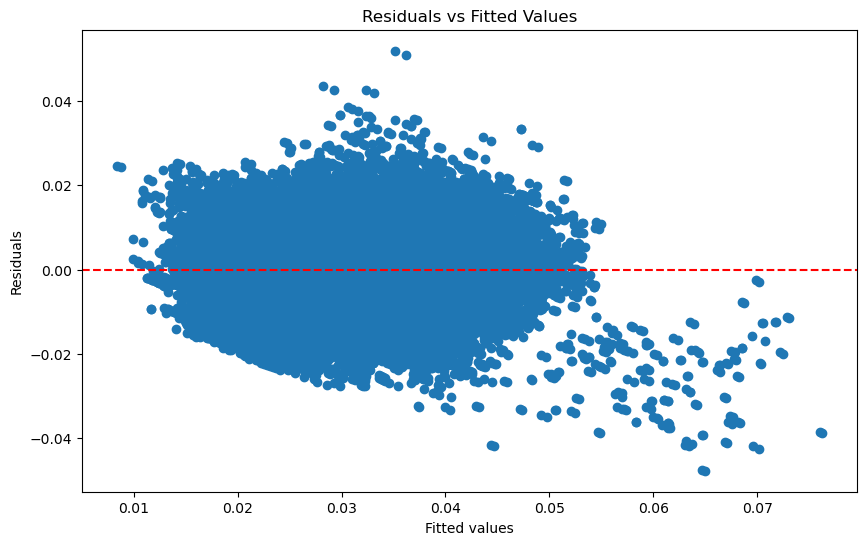

In [49]:
residuals = results.resid

# Plot for Residuals to check for homoscedasticity
plt.figure(figsize=(10, 6))
plt.scatter(results.fittedvalues, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

/Users/krithikanatarajan/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


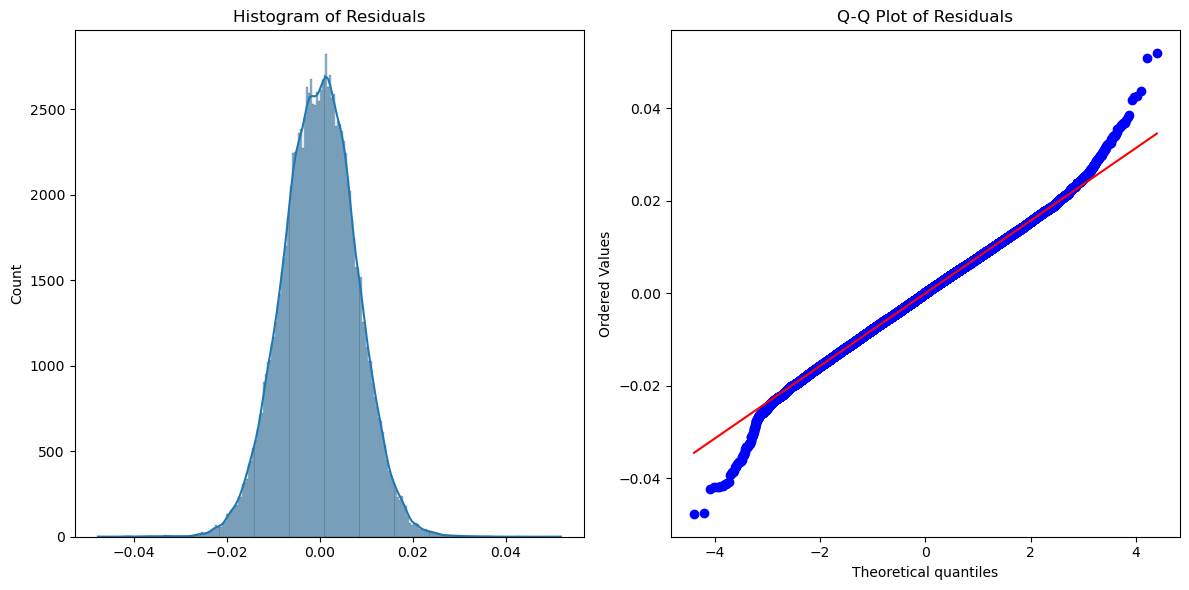

In [50]:
# Histogram and QQ-Plot for Normality of Residuals
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')

plt.subplot(122)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

In [51]:
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_stat}')

Durbin-Watson statistic: 0.3740718212579979


In [52]:
robust_results = results.get_robustcov_results(cov_type='HC3')

# Print out the robust summary results
print(robust_results.summary())

                              OLS Regression Results                             
Dep. Variable:     arithmetic_mean_ozone   R-squared:                       0.450
Model:                               OLS   Adj. R-squared:                  0.450
Method:                    Least Squares   F-statistic:                     6226.
Date:                   Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                           21:13:26   Log-Likelihood:             4.3564e+05
No. Observations:                 127070   AIC:                        -8.712e+05
Df Residuals:                     127054   BIC:                        -8.711e+05
Df Model:                             15                                         
Covariance Type:                     HC3                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

# Linear GAM Model

In [53]:
from pygam import LinearGAM, s, te
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from datetime import datetime

In [54]:
data= northeastern.copy()

In [55]:
data.head()

,date_local,state_name,county_name,city_name,arithmetic_mean_ozone,1st_max_value_ozone,1st_max_hour_ozone,aqi,arithmetic_mean_wind,1st_max_value_wind,...,arithmetic_mean_rhd,1st_max_value_rhd,1st_max_hour_rhd,arithmetic_mean_pressure,1st_max_value_pressure,1st_max_hour_pressure,Season_Fall,Season_Spring,Season_Summer,Season_Winter
374259,2016-03-31,Connecticut,Hartford,East Hartford,0.038500,0.039,22,36,5.608333,8.0,...,61.750000,87.0,23,1011.958333,1018.0,0,0,1,0,0
374260,2016-03-31,Connecticut,Hartford,East Hartford,0.038500,0.039,22,36,198.666667,208.0,...,61.750000,87.0,23,1011.958333,1018.0,0,0,1,0,0
374261,2016-04-01,Connecticut,Hartford,East Hartford,0.034059,0.037,16,34,4.312500,7.0,...,82.333333,93.0,4,1001.083333,1006.0,0,0,1,0,0
374262,2016-04-01,Connecticut,Hartford,East Hartford,0.034059,0.037,16,34,210.666667,340.0,...,82.333333,93.0,4,1001.083333,1006.0,0,0,1,0,0
374263,2016-04-02,Connecticut,Hartford,East Hartford,0.027412,0.035,11,32,1.795833,4.3,...,79.041667,96.0,21,997.250000,1003.0,0,0,1,0,0


In [56]:
predictive_columns = ['arithmetic_mean_wind', '1st_max_value_wind', '1st_max_hour_wind', 
                      'arithmetic_mean_temp', '1st_max_value_temp', '1st_max_hour_temp',
                      'arithmetic_mean_rhd', '1st_max_value_rhd', '1st_max_hour_rhd',
                      'arithmetic_mean_pressure', '1st_max_value_pressure', '1st_max_hour_pressure',
                      'Season_Fall', 'Season_Spring', 'Season_Summer']  # Add or remove columns as needed

# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date_local'])

# Extract year, month, and day as separate columns
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

# Include these in your model as needed
predictive_columns.extend(['month'])

state_dummies = pd.get_dummies(data['state_name'], drop_first=True)  # Avoid the dummy variable trap
data = pd.concat([data, state_dummies], axis=1)

# Update predictive_columns to include the state dummy variables
predictive_columns.extend(state_dummies.columns.tolist())

In [57]:
X = data[predictive_columns]
y = data['arithmetic_mean_ozone']

# Train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,arithmetic_mean_wind,1st_max_value_wind,1st_max_hour_wind,arithmetic_mean_temp,1st_max_value_temp,1st_max_hour_temp,arithmetic_mean_rhd,1st_max_value_rhd,1st_max_hour_rhd,arithmetic_mean_pressure,...,Season_Fall,Season_Spring,Season_Summer,month,Maryland,Massachusetts,New Jersey,New York,Pennsylvania,Virginia
16726147,2.039130,4.4,11,62.833333,68.0,16,73.791667,88.0,2,1023.083333,...,0,0,1,6,False,True,False,False,False,False
22733223,0.800000,1.2,15,35.833333,43.0,14,73.208333,90.0,6,1023.208333,...,1,0,0,11,False,False,False,False,False,False
63518611,6.033333,8.0,18,29.004167,32.0,14,68.750000,80.0,21,991.391667,...,0,0,0,1,False,False,False,False,True,False
529418,3.779167,6.2,0,32.333333,35.0,11,51.208333,88.0,23,1019.250000,...,0,1,0,3,False,True,False,False,False,False
62759332,183.416667,358.0,11,63.291667,73.0,15,66.541667,89.0,3,1006.041667,...,1,0,0,9,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80291608,217.833333,244.0,12,82.500000,89.0,11,66.250000,82.0,23,1019.708333,...,0,0,1,8,False,True,False,False,False,False
63502046,130.208333,175.0,7,42.166667,50.0,12,49.708333,78.0,22,1023.416667,...,0,1,0,4,False,False,False,True,False,False
375119,2.037500,3.7,2,66.375000,68.0,0,97.583333,99.0,2,957.833333,...,1,0,0,9,False,False,False,False,False,False
1413161,236.541667,302.0,2,63.833333,72.0,10,61.708333,86.0,3,1000.916667,...,0,1,0,5,False,False,False,True,False,False


In [58]:


# Prepare the data, setting up the model terms
# The indices for the splines are placeholders; replace them with the correct column indices from your data
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12)).fit(X_train, y_train)

# Cross-validation

cv = KFold(n_splits=5, random_state=42, shuffle=True)  # 5-fold cross-validation

# This will store the cross-validation results
cv_r2_scores = []
cv_mse_scores = []

for train_index, val_index in cv.split(X_train):
    # Split the data into K-folds
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Fit the model on the training fold
    gam.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_pred_fold = gam.predict(X_val_fold)
    
    # Calculate R-squared and Mean Squared Error
    cv_r2_scores.append(r2_score(y_val_fold, y_pred_fold))
    cv_mse_scores.append(mean_squared_error(y_val_fold, y_pred_fold))

# Average R-squared and MSE across all folds
average_r2_score = np.mean(cv_r2_scores)
average_mse_score = np.mean(cv_mse_scores)
print(f'Average R-squared across all folds: {average_r2_score}')
print(f'Average MSE across all folds: {average_mse_score}')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
# Fit the model on the full training data one more time
gam.fit(X_train, y_train)

# Predict on the test set
y_pred_test = gam.predict(X_test)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.I

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
# Calculate R-squared and Mean Squared Error for the test set
test_r2_score = r2_score(y_test, y_pred_test)
test_mse_score = mean_squared_error(y_test, y_pred_test)
print(f'R-squared on the test set: {test_r2_score}')
print(f'MSE on the test set: {test_mse_score}')

In [ ]:
# Assuming 'gam' is your fitted GAM model and 'X_test' and 'y_test' are your test sets
y_pred = gam.predict(X_test)
residuals = y_test - y_pred

# Check for Homoscedasticity
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

In [ ]:
# Check for Normality of Residuals
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')

plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

In [ ]:
dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_stat}')

In [ ]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    
    plt.figure()
    plt.plot(XX[:, i], pdep)
    plt.fill_between(XX[:, i], confi[:, 0], confi[:, 1], alpha=0.2)
    plt.title(f'Partial Dependence for feature {X_test.columns[i]}')
    plt.show()